# Male Sexlessness

The Institute for Family Studies is running an article about Incels, [Male Sexlessness is Rising But Not for the Reasons Incels Claim](https://ifstudies.org/blog/male-sexlessness-is-rising-but-not-for-the-reasons-incels-claim?fbclid=IwAR0GYoTt6c6J2x2d1mU6DTOIlUcbGFFoGPsZoInctRU24Mcyy232-p17gUQ), which uses data from the General Social Survey. The GSS is easy to process and use, so I decided to try to replicate the chart in the article

<img src="https://ifstudies.org/ifs-admin/resources/2-comparison-graph-w640.png">

That's a very steep increase from 2010, and I'm skeptical, especially because, as the article notes, the rise is not supported by NHANES nor NSFG. 

The only solid information I could find about how the GSS data is processed is at the botton of the chart: 

>NHANES and GSSS pooling on samples on 2 years of each side of the label year. ... GSS "Never Married", 
>

To do this analysis, used the [GSS Data Explorer](https://gssdataexplorer.norc.org/) to extract these variables: 

    year      Gss year for this respondent                       
    sexfreq   Frequency of sex during last year
    partners  How many sex partners r had in last year
    marital   Marital status
    id_       Respondent id number
    
You can download the data package from my [GSS project for this analysis. ](https://gssdataexplorer.norc.org/projects/69138). 

Based on the comment on the chart, this analysis will: 

* Extract the males who are never married and between 22 and 35 years old, inclusive. 
* Group by year and count the number of respondents who report no sex in last year for sexual frequence
* Group by year and count the number of respondents who report no sex partners in last year
* Average the two previous counts, per year. 
* Compute the 5 year rolling average of the counts
* Divide the rolling average by the number of respondents

The query to extract the sub-group of respondents is:

    "year >= 1988 and marital == 'Never married' and sex == 'Male' and age >=22 and age<= 35 "

The result is a completely different chart. 

You can get the [Jupyter notebook for this analysis](https://github.com/ericbusboom/data_analysis/blob/master/Incels/Incels.ipynb) from Github, or [view it online at nbviewer.](https://nbviewer.jupyter.org/github/ericbusboom/data_analysis/blob/master/Incels/Incels.ipynb)


In [1]:
import seaborn as sns
import pandas as pd
import geopandas as gpd
import descartes
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display 

In [8]:
df = pd.read_csv('GSS.csv', low_memory=False)

# Replace the question titles with variable names
df.columns = """year
ballot
evpaidsx
sexsex5
partnrs5
sexfreq
partners
absingle
race
sex
educ
age
widowed
divorce
marital
id_
wtss""".splitlines()



Text(0.5, 1.0, 'Percent 22 to 35 YO Males, No Sex in Last Year')

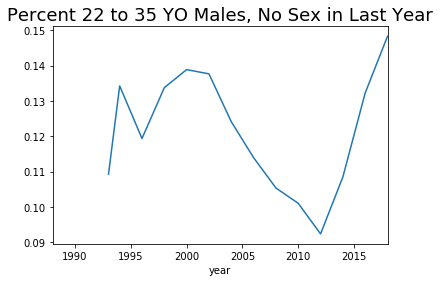

In [16]:
# Fix non-numerics
df['age'] = pd.to_numeric(df.age, errors='coerce')
df['year'] = pd.to_numeric(df.year, errors='coerce')

# Sub-group query
sg = df.query("year >= 1988 and marital == 'Never married' and sex == 'Male' and age >=22 and age<= 35 ")

total = sg.groupby('year').sum()[['wtss']]

t1 = sg.groupby(['year','partners']).sum()[['wtss']].unstack().fillna(0)
t1.columns = t1.columns.droplevel()
t1 = t1[['No partners']]

t2 =sg.groupby(['year','sexfreq']).sum()[['wtss']].unstack().fillna(0)
t2.columns = t2.columns.droplevel()
t2 = t2[['Not at all']]

t = total.join(t1).join(t2)
t.columns = ['total', 'no_partners','no_sex']
t['ns_np_mean'] = (t.no_partners + t.no_sex)/2

t = t.rolling(5).sum()

t['ns_np_pct'] = (t.ns_np_mean / t.total)

ax = t.ns_np_pct.plot()
ax.set_title('Percent 22 to 35 YO Males, No Sex in Last Year', fontsize=18)
